# Team rADAtouille - Milestone 2

This notebook aims to preprocess our data, and estimate the feasibility of the different ideas we had during the first milestone, using data exploration and some preliminary analysis.

On today's menu:
- [Dataset description](#Dataset-description)
- [Initial dataset preprocessing](#Data-preprocessing)
    - [Characters dataset](#Characters-dataset) 
    - [Movies dataset](#Movies-dataset)
    - [Plot summaries dataset](#Plot-summaries-dataset)
- [External datasets](#External-datasets)
- [Data merging](#Data-merging)
- [Data exploration](#Data-exploration)

# Datasets description

This project utilizes a rich collection of datasets encompassing movies, characters, and plot summaries. The primary datasets include:

- **Characters Dataset** (`character.metadata.tsv`): Contains detailed metadata on movie characters and the actors portraying them. Key attributes include Wikipedia and Freebase IDs, movie release dates, character names, actor birthdates, genders, heights, ethnicities, and ages at the time of movie release.

- **Movies Dataset** (`movie.metadata.tsv`) Includes comprehensive information about movies. It features data such as Wikipedia and Freebase IDs, movie names, release dates, box office revenues, runtimes, languages, countries, and genres.

- **Plot Summaries Dataset** (`plot_summaries.text`): Offers a concise summary of movie plots, linked to movies through Wikipedia movie IDs.

### External datasets

We also use external datasets to enrich our data. More information about these datasets can be found in the [External datasets](#External-datasets) section.

- **IMDB Users Ratings** (`title.ratings.tsv`): Contains the IMDB number of votes and the average rating for each movie.

- **Metacritic Critics Ratings** (`metacritic_reviews.csv`): Contains the Metacritic critics rating for each movie with the metascore, publisher and author.

- **Awards** (`imdb_awards.csv`): Contains the awards nominations and wins for each movie.


# Initial dataset preprocessing

## Characters dataset

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import datetime


In [155]:
# Load the data
df_characters = pd.read_table('data/raw/character.metadata.tsv', names=['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age_at_movie_release', 'freebase_actor_map_id', 'freebase_character_id', 'freebase_actor_id'])
df_characters.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


Let's check if we can find some missing values in the dataset.

In [156]:
df_characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   wikipedia_id                450669 non-null  int64  
 1   freebase_id                 450669 non-null  object 
 2   release_date                440674 non-null  object 
 3   character_name              192794 non-null  object 
 4   actor_dob                   344524 non-null  object 
 5   actor_gender                405060 non-null  object 
 6   actor_height                154824 non-null  float64
 7   actor_ethnicity             106058 non-null  object 
 8   actor_name                  449441 non-null  object 
 9   actor_age_at_movie_release  292556 non-null  float64
 10  freebase_actor_map_id       450669 non-null  object 
 11  freebase_character_id       192804 non-null  object 
 12  freebase_actor_id           449854 non-null  object 
dtypes: float64(2),

We can identify from the output above that:
- There are some *missing values*
- Some *type are not exploitable* (e.g. the `release_date` and `actor_dob`  are `object`s, not exploitable dates)

Concerning the *missing values* problem, we have 3 options: not using the problematic columns, dropping the rows or filling the missing values using external source.

Now we'll take a look at the values and see if we can find some outliers.

In [157]:
df_characters.describe(include='all')

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_actor_map_id,freebase_character_id,freebase_actor_id
count,4.506690e+05,450669,440674,192794,344524,405060,154824.000000,106058,449441,292556.000000,450669,192804,449854
unique,NaN,64330,18476,126629,29494,2,NaN,479,134078,NaN,450669,183435,135760
top,NaN,/m/0cc8620,2008,Doctor,1908-05-30,M,NaN,/m/0dryh9k,Mel Blanc,NaN,/m/0bgchxw,/m/0h577m2,/m/0c5vh
freq,NaN,115,5453,198,791,270257,NaN,16351,791,NaN,1,146,791
mean,1.396975e+07,NaN,NaN,NaN,NaN,NaN,1.788893,NaN,NaN,37.788523,NaN,NaN,NaN
std,1.079662e+07,NaN,NaN,NaN,NaN,NaN,4.379940,NaN,NaN,20.587870,NaN,NaN,NaN
min,3.300000e+02,NaN,NaN,NaN,NaN,NaN,0.610000,NaN,NaN,-7896.000000,NaN,NaN,NaN
25%,3.759292e+06,NaN,NaN,NaN,NaN,NaN,1.676400,NaN,NaN,28.000000,NaN,NaN,NaN
50%,1.189065e+07,NaN,NaN,NaN,NaN,NaN,1.750000,NaN,NaN,36.000000,NaN,NaN,NaN
75%,2.366501e+07,NaN,NaN,NaN,NaN,NaN,1.830000,NaN,NaN,47.000000,NaN,NaN,NaN


Uh, we can find a few interesting results:
- How can an actors' height be 510m ? 
- How can an actor's age be negative ?

### Release date

To tackle the type problem we can convert the `object` type to `datetime` type.

In [158]:
df_characters['release_date'].sample(10)

446608    1987-03-06
77904     1995-02-03
351402    1965-05-12
419866    1936-11-08
148482          1997
137991          1975
8777             NaN
390884    2008-01-25
376354           NaN
428734    1934-09-21
Name: release_date, dtype: object

In [159]:
def safe_convert_to_datetime(date_str):
    try:
        return datetime.datetime.strptime(date_str, '%Y-%m-%d')
    except (ValueError, TypeError):
        try:
            return datetime.datetime.strptime(date_str, '%Y')
        except (ValueError, TypeError):
            try:
                return datetime.datetime.strptime(date_str, '%Y-%m')
            except (ValueError, TypeError):
                return None

# Convert the date strings to datetime objects
df_characters['release_date_datetime'] = df_characters['release_date'].apply(safe_convert_to_datetime)
df_characters['release_date_datetime'] = pd.to_datetime(df_characters['release_date_datetime'], errors='coerce')

print('Have lost %d release dates'%(df_characters['release_date_datetime'].isna().sum() - df_characters['release_date'].isna().sum()), 'now there are %d missing'%(df_characters['release_date_datetime'].isna().sum()))

Have lost 15 release dates now there are 10010 missing


### Date of birth

We can also convert the `object` type to `datetime` type, same as before.

In [160]:
# Convert the date strings to datetime objects
df_characters['actor_dob_datetime'] = df_characters['actor_dob'].apply(safe_convert_to_datetime)
df_characters['actor_dob_datetime'] = pd.to_datetime(df_characters['actor_dob_datetime'], errors='coerce')

print('Have lost %d actors dob'%(df_characters['actor_dob_datetime'].isna().sum() - df_characters['actor_dob'].isna().sum()), 'now there are %d missing'%(df_characters['actor_dob_datetime'].isna().sum()))

Have lost 34 actors dob now there are 106179 missing


### Height

In [161]:
df_characters[df_characters['actor_height'] > 2.5]

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_actor_map_id,freebase_character_id,freebase_actor_id,release_date_datetime,actor_dob_datetime
21619,1291587,/m/04qk12,2004-09-01,young Georgie,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,18.0,/m/0k276dx,/m/0k276dz,/m/0bggwvl,2004-09-01,1986-03-13
49659,30865068,/m/02ml14,1998-10-15,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0n9ld0y,NaN,/m/08hqh0,1998-10-15,1972-12-06
59719,12206655,/m/02vvw24,NaN,Dominic,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,NaN,/m/0k276dq,/m/0h8hcr1,/m/0bggwvl,NaT,1986-03-13
104140,17999628,/m/047n_2q,1998,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0cg31bd,NaN,/m/08hqh0,1998-01-01,1972-12-06
205679,1373475,/m/04xmx8,2003-08-15,Jackal Johnson,1972-12-06,M,510.0,NaN,Vince Corazza,30.0,/m/02vbm0k,/m/0h60xk7,/m/08hqh0,2003-08-15,1972-12-06
219383,179326,/m/018gq3,1996-11-18,Herbert,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,10.0,/m/0bggwv8,/m/0bggwvc,/m/0bggwvl,1996-11-18,1986-03-13
301653,4667507,/m/0cg9n6,2001-11-29,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,28.0,/m/0cg0zwp,NaN,/m/08hqh0,2001-11-29,1972-12-06
316621,3915041,/m/0b6lyp,2002,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,29.0,/m/02vc5p5,NaN,/m/08hqh0,2002-01-01,1972-12-06
341890,29290087,/m/0b3w9mr,1997-04-07,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,24.0,/m/0gvwy8x,NaN,/m/08hqh0,1997-04-07,1972-12-06
360967,14413223,/m/03d2rnl,2012-04-20,Young Punk Guy,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,26.0,/m/0m4q87d,/m/0k9tfs8,/m/0bggwvl,2012-04-20,1986-03-13


Using a few google searches, we found that for the 510.0m problem, the actor's height is 5'10" (1.78m). We'll fix this value.
Concerning the 180m problem, we can guess that the actor's height is 1.80m, but we can't find any source to confirm this (internet or other rows). We'll drop these row (4).

In [162]:
df_characters.drop(df_characters[df_characters['actor_height'] > 2.5].index, inplace=True)

### Age

Let's then take care of the age problem.

In [163]:
print(df_characters.loc[(df_characters['actor_age_at_movie_release'] < 0)].shape[0], 'such rows are concerned')
df_characters = df_characters[df_characters['actor_age_at_movie_release'] > 0]

381 such rows are concerned


In [164]:
# Count the number of actor born after the movie release
df_characters[df_characters['actor_dob_datetime'] > df_characters['release_date_datetime']].shape[0]

0

### Check for duplicates

This hence not a problem! We also look for duplicates.

In [165]:
# Drop the rows that have duplicates
df_characters.drop_duplicates(subset=['freebase_id', 'freebase_actor_id', 'freebase_character_id'], inplace=True)

### Save the processed dataset

In [166]:
# Drop the columns that are not useful
df_characters.drop(columns=['actor_dob', 'release_date'], inplace=True)

# Save the processed data
df_characters.to_csv('data/preprocessed/character.metadata.preprocessed.tsv', sep='\t', index=False)

## Movie dataset

In [167]:
# For the movies metadata
df_movies = pd.read_table('data/raw/movie.metadata.tsv', names=['wikipedia_id', 'freebase_id', 'name', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres'], header=None)

In [168]:
print(df_movies.info())

#check for NaN values for each columns
print('\nCheck for NaN values:')
print(df_movies.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wikipedia_id  81741 non-null  int64  
 1   freebase_id   81741 non-null  object 
 2   name          81741 non-null  object 
 3   release_date  74839 non-null  object 
 4   revenue       8401 non-null   float64
 5   runtime       61291 non-null  float64
 6   languages     81741 non-null  object 
 7   countries     81741 non-null  object 
 8   genres        81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB
None

Check for NaN values:
wikipedia_id        0
freebase_id         0
name                0
release_date     6902
revenue         73340
runtime         20450
languages           0
countries           0
genres              0
dtype: int64


In [169]:
#Check for duplicate entries
print('Check for duplicate entries:')
print(df_movies.duplicated().sum())

#Check for duplicate entries with name only
print('Check for duplicate entries with name only:')
print(df_movies.duplicated(subset=['name']).sum())

#Check for duplicate entries with name and date release only
print('Check for duplicate entries with name and date release:')
print(df_movies.duplicated(subset=['name', 'release_date']).sum())

#Check for duplicate entries with name and date release only
print('Check for duplicate entries with name and movie runtime:')
print(df_movies.duplicated(subset=['name', 'runtime']).sum())

#Check for duplicate entries with name and date release only
print('Check for duplicate entries with wikipedia ID:')
print(df_movies.duplicated(subset=['wikipedia_id']).sum())

Check for duplicate entries:


0
Check for duplicate entries with name only:
6263
Check for duplicate entries with name and date release:
103
Check for duplicate entries with name and movie runtime:
628
Check for duplicate entries with wikipedia ID:
0


We have some duplicate entries on the name but the wikipedia ID is always unique

In [170]:
df_movies.describe(include='all')

,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres
count,8.174100e+04,81741,81741,74839,8.401000e+03,6.129100e+04,81741,81741,81741
unique,NaN,81741,75478,20389,NaN,NaN,1817,2124,23817
top,NaN,/m/03vyhn,Alice in Wonderland,2006,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
freq,NaN,1,17,1011,NaN,NaN,33748,30300,6851
mean,1.740784e+07,NaN,NaN,NaN,4.799363e+07,1.118192e+02,NaN,NaN,NaN
std,1.098791e+07,NaN,NaN,NaN,1.121753e+08,4.360070e+03,NaN,NaN,NaN
min,3.300000e+02,NaN,NaN,NaN,1.000000e+04,0.000000e+00,NaN,NaN,NaN
25%,7.323695e+06,NaN,NaN,NaN,2.083193e+06,8.100000e+01,NaN,NaN,NaN
50%,1.777899e+07,NaN,NaN,NaN,1.063969e+07,9.300000e+01,NaN,NaN,NaN
75%,2.715573e+07,NaN,NaN,NaN,4.071696e+07,1.060000e+02,NaN,NaN,NaN


Looking at the output, we may have a few observations:
- Is there a problem with the `release_date` column ? There is at least one entry with a date in the future compared to when the dataset was released.
- The `runtime` column seems to have some outliers, with at least one movie with a runtime of 0, and one of 1 million minutes (multiple months).

### Release date

We have a similar date problem as the one we had with the characters dataset. We'll fix it the same way.

In [171]:
def safe_convert_to_datetime(date_str):
    try:
        return datetime.datetime.strptime(date_str, '%Y-%m-%d')
    except (ValueError, TypeError):
        try:
            return datetime.datetime.strptime(date_str, '%Y')
        except (ValueError, TypeError):
            try:
                return datetime.datetime.strptime(date_str, '%Y-%m')
            except (ValueError, TypeError):
                return None

# Convert the date strings to datetime objects
df_movies['release_date_datetime'] = df_movies['release_date'].apply(safe_convert_to_datetime)
df_movies['release_date_datetime'] = pd.to_datetime(df_movies['release_date_datetime'], errors='coerce')

print('Have lost %d release dates'%(df_movies['release_date_datetime'].isna().sum() - df_movies['release_date'].isna().sum()), 'now there are %d missing'%(df_movies['release_date_datetime'].isna().sum()))

Have lost 1 release dates now there are 6903 missing


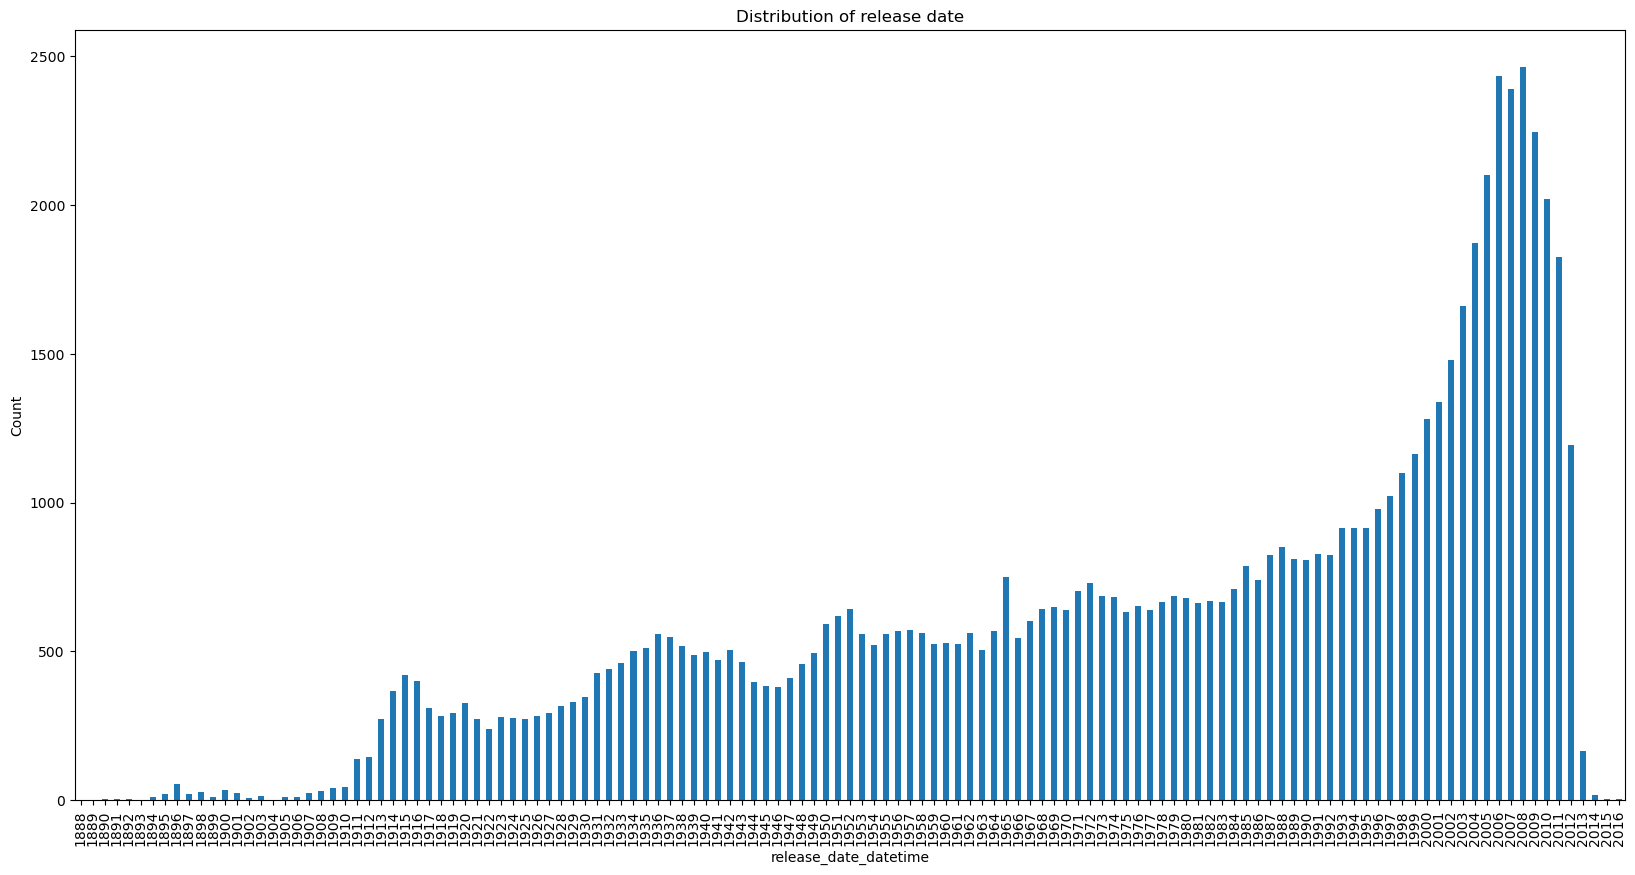

In [172]:
# Plot the distribution of the movie release date
plt.figure(figsize=(20, 10))
plt.title('Distribution of release date')
plt.xlabel('Release date')
plt.ylabel('Count')
df_movies.dropna(subset=['release_date_datetime'])['release_date_datetime'].dt.year.sort_values().value_counts(sort=False).plot(kind='bar')
plt.show()

In [173]:
print(f"There are {df_movies[df_movies['release_date_datetime'] >= pd.to_datetime('2014')].shape[0]} movies are after 2014:")
df_movies[df_movies['release_date_datetime'] >= pd.to_datetime('2014')]

There are 24 movies are after 2014:


,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,release_date_datetime
2768,35343769,/m/0j9qc6b,Gokula Krishna,2014-04-02,NaN,NaN,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",2014-04-02
8307,24179103,/m/0jwx0kc,"I, Robot 2",2015,NaN,NaN,{},{},"{""/m/06n90"": ""Science Fiction""}",2015-01-01
8522,29327224,/m/0ds2124,The Familiars,2014,NaN,NaN,{},{},"{""/m/01zhp"": ""Computer Animation""}",2014-01-01
14761,11558668,/m/02rj3br,First Man,2014,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z4y"": ""Comedy""}",2014-01-01
30275,27554912,/m/0c03gcc,Kung Fu Panda 3,2016-03-18,NaN,NaN,{},{},{},2016-03-18
34022,23124260,/m/064mmw7,Jeepers Creepers 4,2016-06-08,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}",2016-06-08
34454,35764246,/m/0jt01_6,Appayya,2014-08-15,NaN,NaN,"{""/m/09bnf"": ""Kannada Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film""}",2014-08-15
34896,36534974,/m/0kdy118,Noah,2014-03-28,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01hmnh"": ""Fantasy""}",2014-03-28
36528,5803355,/m/0f5r4p,Voltron,2014,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/02kdv5l"": ""Action"", ""/m/01hmnh"": ""Fantasy...",2014-01-01
40166,2312141,/m/072zwn,Knight Rider: The Movie,2015,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/06n90"": ""Sci...",2015-01-01


We can see that there are 24 occurence of movies that were released after the release of the dataset. In order to have a more representative dataset, we'll drop these rows.

In [174]:
old_shape = df_movies.shape[0]
df_movies.drop(df_movies[df_movies['release_date_datetime'] >= pd.to_datetime('2014')].index, inplace=True)
print(f"Have removed {old_shape - df_movies.shape[0]} movies")

Have removed 24 movies


### Runtime

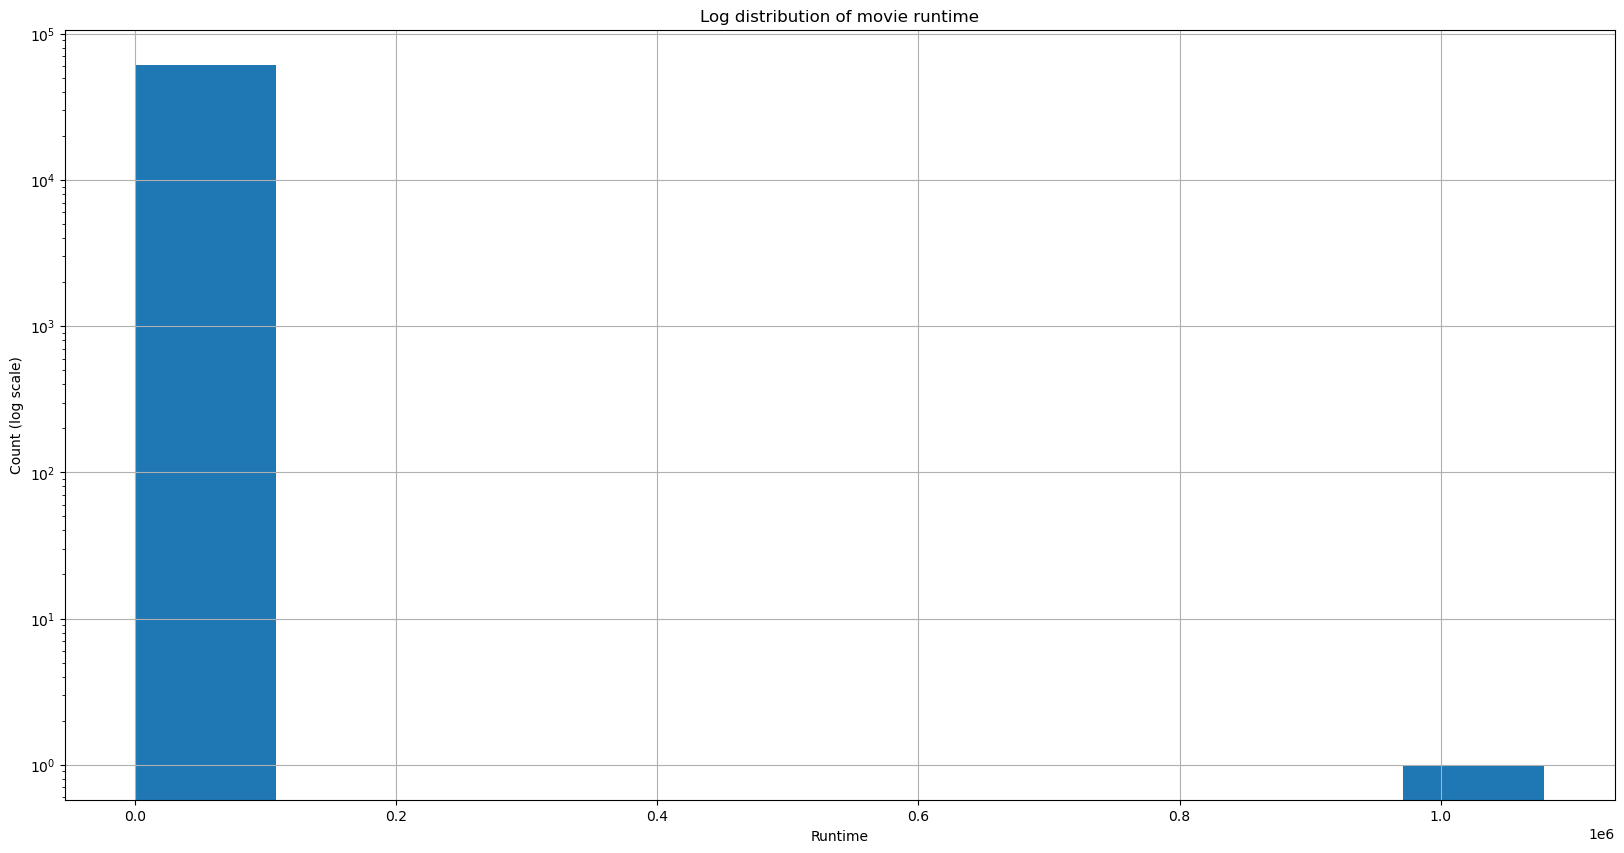

In [175]:
# Plot the distribution of the movie runtime
plt.figure(figsize=(20,10))
plt.title('Log distribution of movie runtime')
plt.xlabel('Runtime')
plt.ylabel('Count (log scale)')
plt.yscale('log')
df_movies.dropna(subset=['runtime'])['runtime'].hist(bins=10)
plt.show()

We can see that there are some outliers in the runtime column. We'll drop the rows with a runtime less or equal to 0 and greater than 500 minutes. 

In [176]:
old_shape = df_movies.shape[0]
df_movies.drop(df_movies[df_movies['runtime'] > 500].index, inplace=True)
df_movies.drop(df_movies[df_movies['runtime'] <= 0].index, inplace=True)
print(f"Have lost {old_shape - df_movies.shape[0]} rows")

Have lost 47 rows


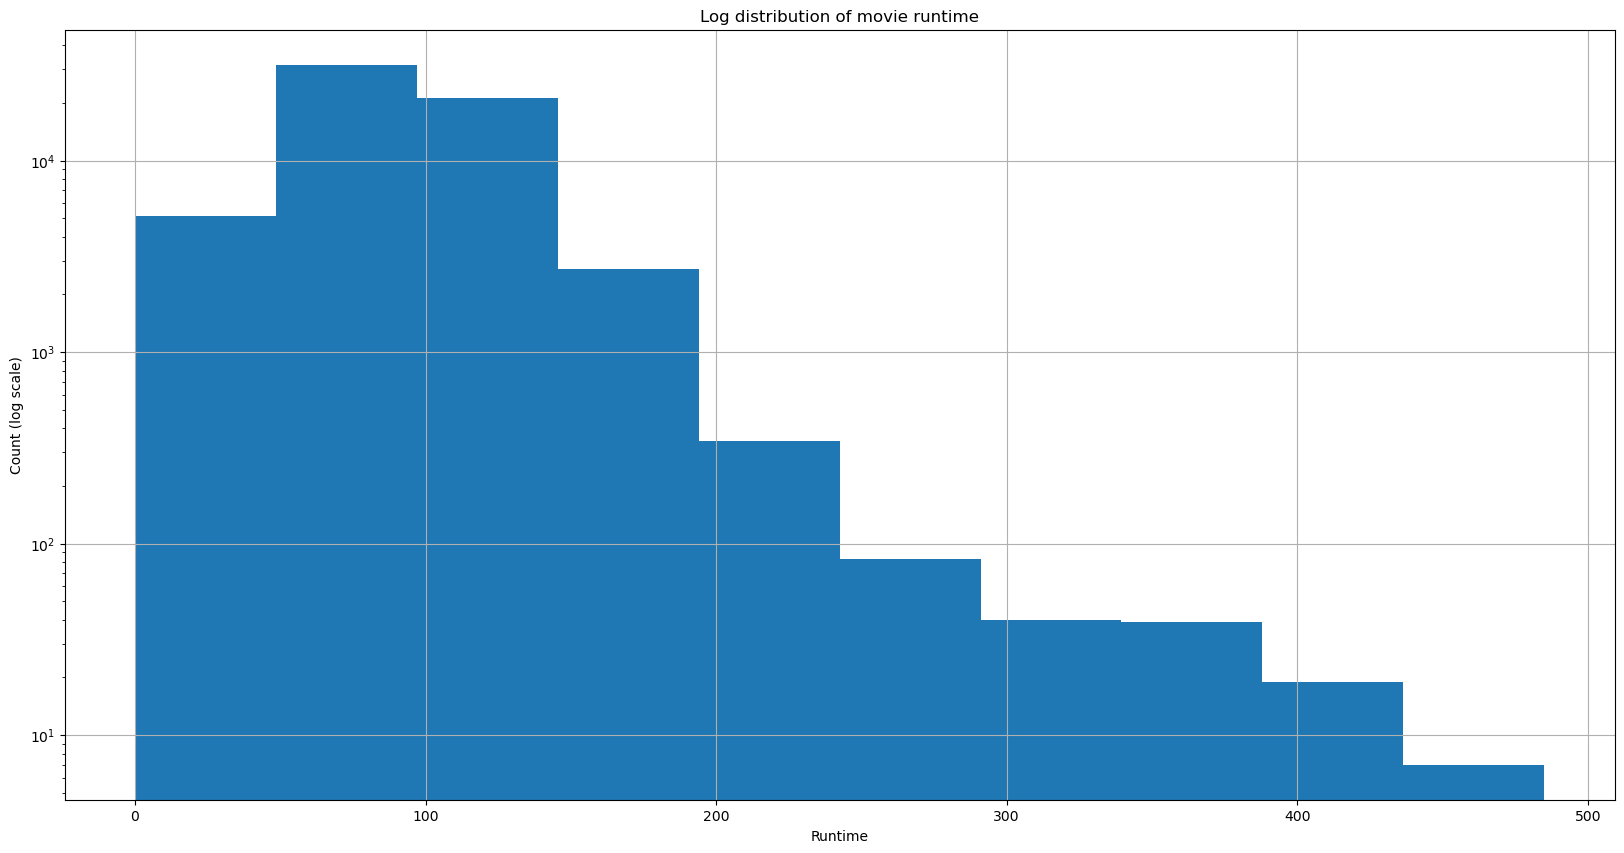

In [177]:
plt.figure(figsize=(20,10))
plt.title('Log distribution of movie runtime')
plt.xlabel('Runtime')
plt.ylabel('Count (log scale)')
plt.yscale('log')
df_movies.dropna(subset=['runtime'])['runtime'].hist(bins=10)
plt.show()

### Genres

We can see that the `genres` column is a dict of genres. We'll explode this column to have a row for each genre.

In [178]:
def extract_list(row, type):
    '''
    Extract the list of values from a dictionary
    
    Params:
    - row (pandas.Series): the row of the dataframe
    - type (str): the type of the column to explode

    Return: the list of the values of the dictionary

    '''
    try:
        values_dict = ast.literal_eval(row[type])
        return list(values_dict.values())
    except:
        return []

In [179]:
# Extract the list of genres
df_movies['extracted_genres'] = df_movies.apply(lambda row: extract_list(row, 'genres'), axis=1)

# Explode the genres
df_movies_exploded = df_movies.explode('extracted_genres')

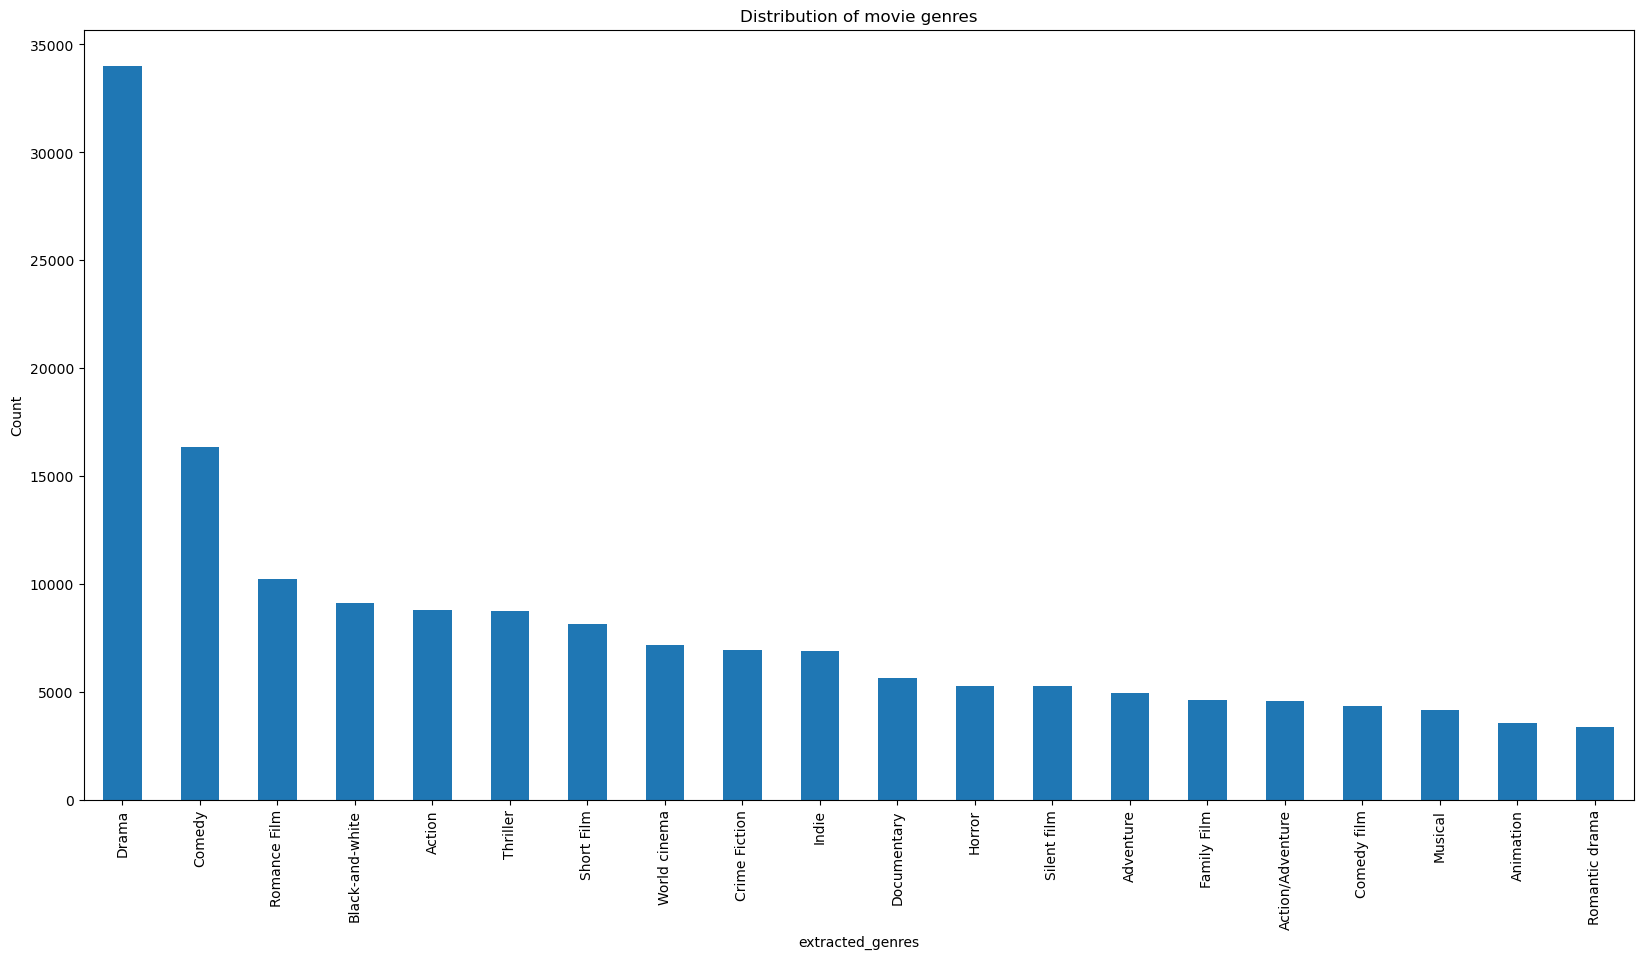

In [180]:
# Plot the distribution of movie genres, for the top 20 genres
plt.figure(figsize=(20,10))
plt.title('Distribution of movie genres')
plt.xlabel('Movie genres')
plt.ylabel('Count')
df_movies_exploded['extracted_genres'].value_counts().head(20).plot(kind='bar')
plt.show()

### Countries

Similarly to the `genres` column, the `countries` column is a dict of countries. We'll explode this column to have a row for each country.

In [181]:
# Extract the list of countries
df_movies['extracted_countries'] = df_movies.apply(lambda row: extract_list(row, 'countries'), axis=1)

# Explode the countries
df_movies_exploded = df_movies.explode('extracted_countries')

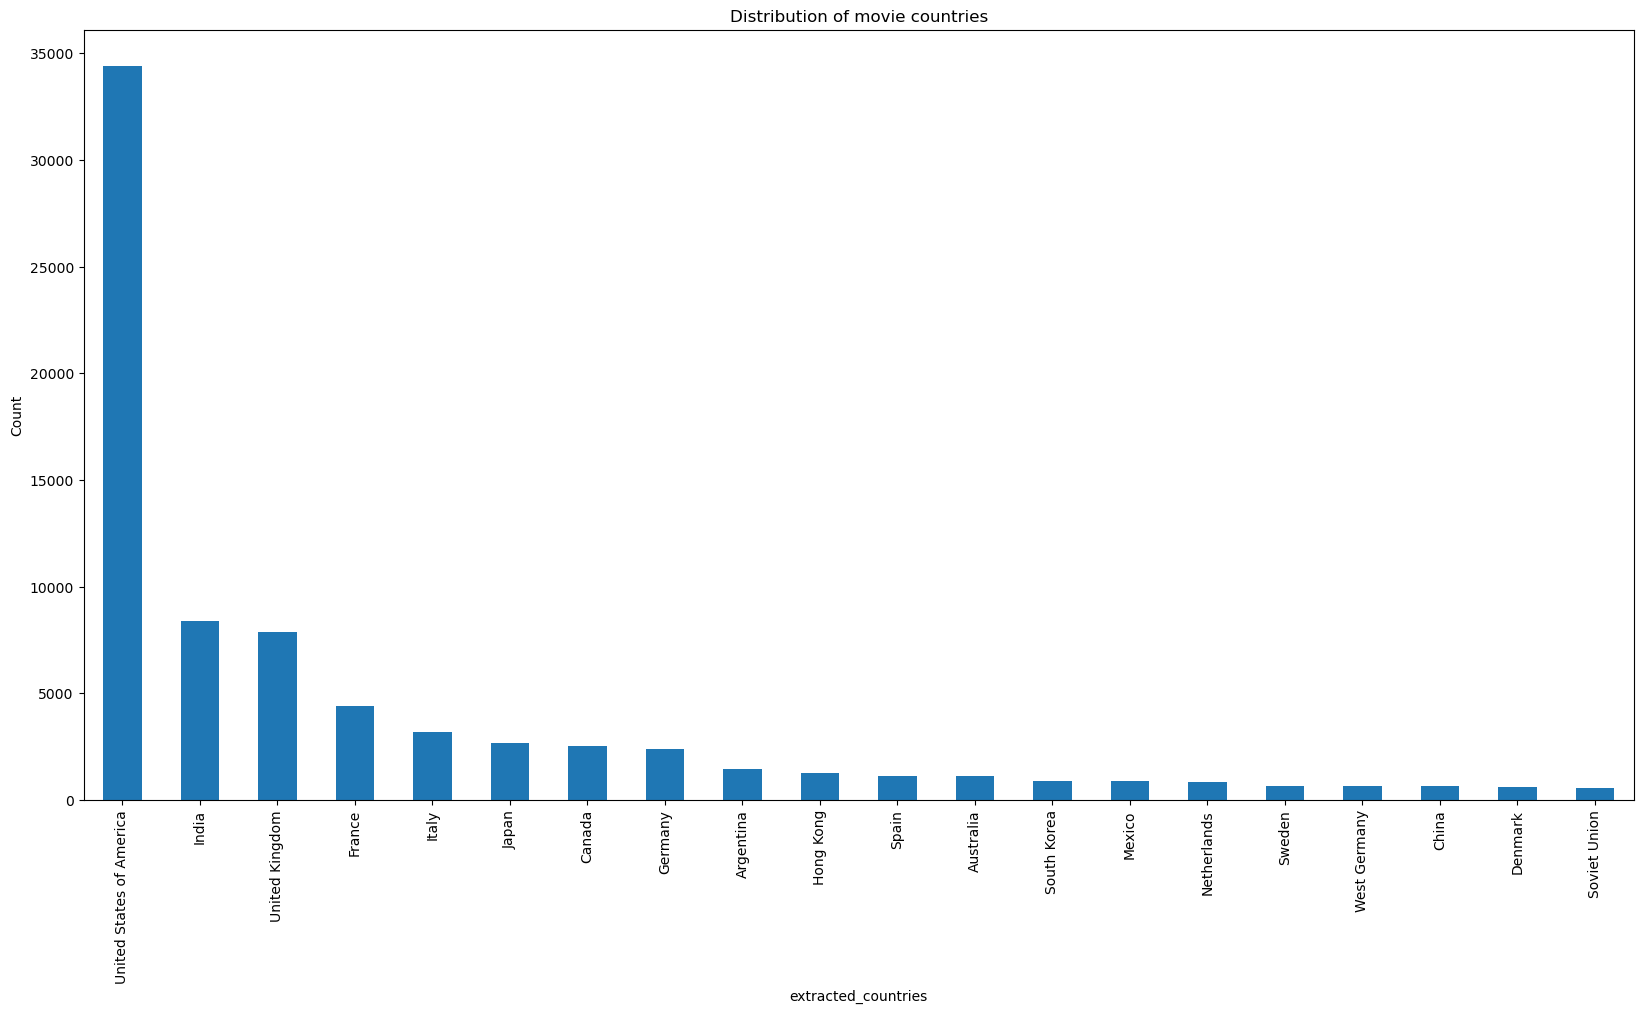

In [182]:
# Plot the distribution of movie countries, for the top 20 countries
plt.figure(figsize=(20,10))
plt.title('Distribution of movie countries')
plt.xlabel('Movie countries')
plt.ylabel('Count')
df_movies_exploded['extracted_countries'].value_counts().head(20).plot(kind='bar')
plt.show()

We can see that the USA is by far the most represented country in the dataset, followed by India, the UK and France.

### Languages

Similarly to the `genres` column, the `languages` column is a dict of languages. We'll explode this column to have a row for each language.

In [183]:
# Extract the list of languages
df_movies['extracted_languages'] = df_movies.apply(lambda row: extract_list(row, 'languages'), axis=1)

# Explode the languages
df_movies_exploded = df_movies.explode('extracted_languages')

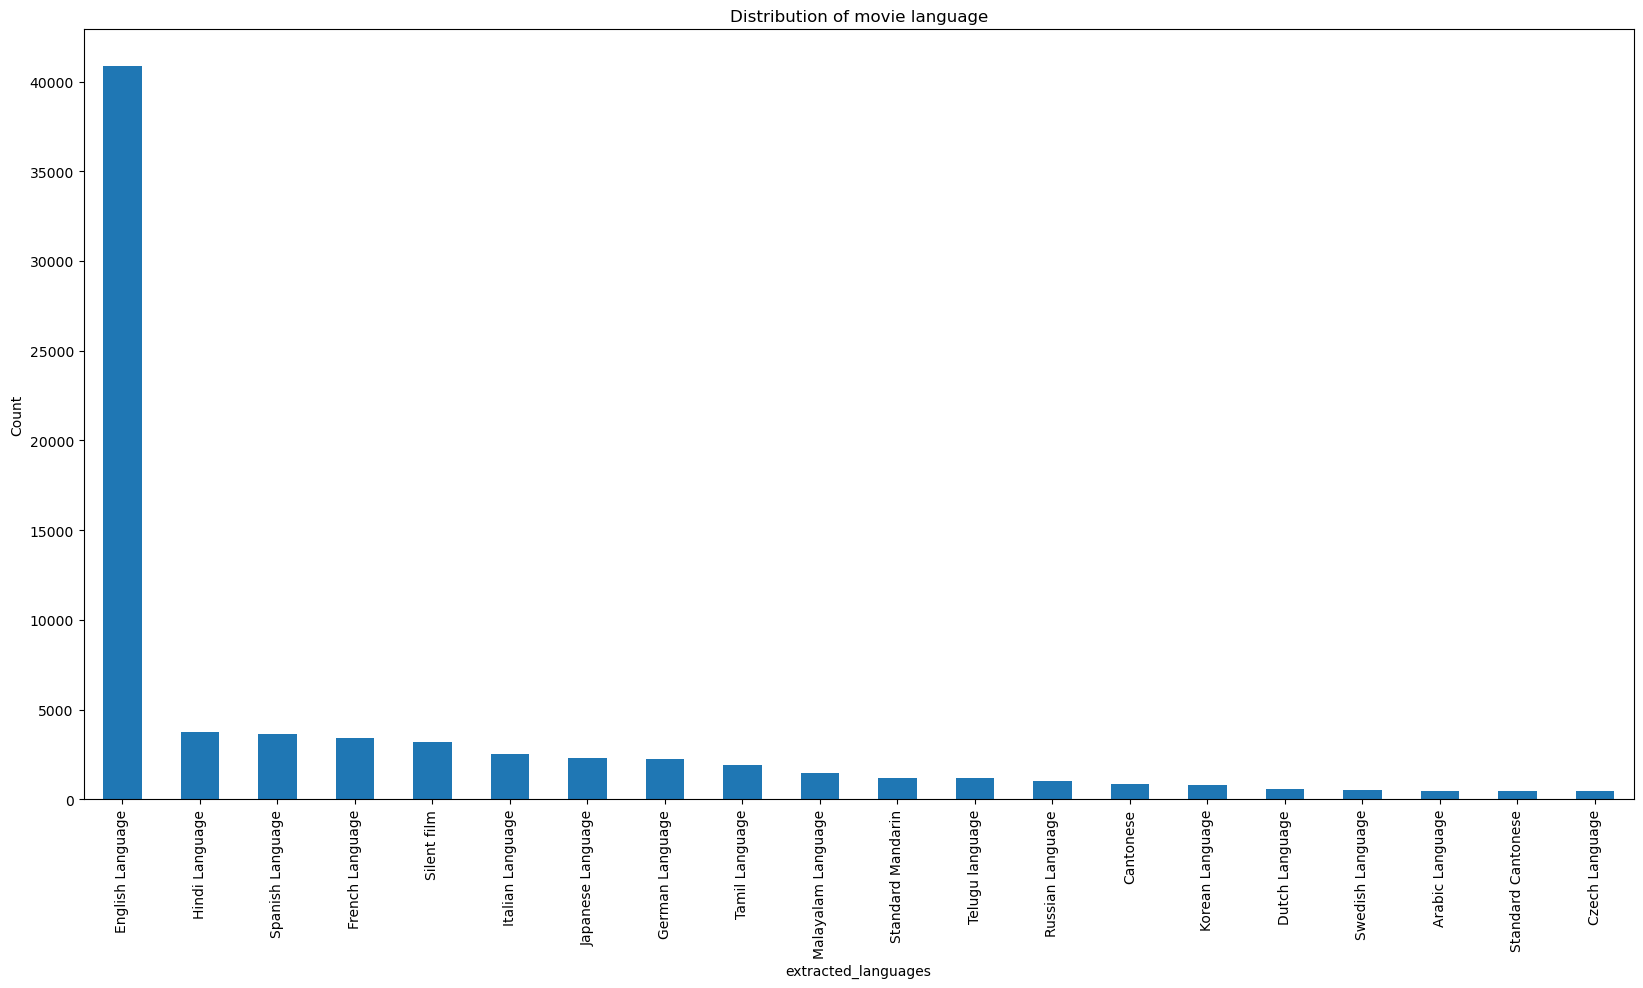

In [184]:
# Plot the distribution of movie language, for the top 20 languages
plt.figure(figsize=(20,10))
plt.title('Distribution of movie language')
plt.xlabel('Movie language')
plt.ylabel('Count')
df_movies_exploded['extracted_languages'].value_counts().head(20).plot(kind='bar')
plt.show()

We can see that English is by far the most represented language in our dataset.

### Save the processed dataset

In [185]:
# Drop the columns that are not useful
df_movies.drop(columns=['release_date', 'extracted_genres', 'extracted_languages', 'extracted_countries'], inplace=True)

# Save the processed dataframe
df_movies.to_csv('data/preprocessed/movie.metadata.preprocessed.tsv', sep='\t', index=False)

## Plot summaries dataset

In [186]:
# For the plot summaries
df_plots = pd.read_table('data/raw/plot_summaries.txt', names=['wikipedia_id', 'plot_summary'], header=None)

In [187]:
df_plots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   wikipedia_id  42303 non-null  int64 
 1   plot_summary  42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


In [188]:
print(f"There are {df_plots.duplicated(subset=['plot_summary']).sum()} duplicated plot summaries:")
df_plots[df_plots.duplicated(subset=['plot_summary'])]

There are 8 duplicated plot summaries:


,wikipedia_id,plot_summary
14631,14055212,A woman is thrown out of her home by her jealo...
29428,14022275,A woman is thrown out of her home by her jealo...
30987,14051944,A woman is thrown out of her home by her jealo...
31702,14053389,A woman is thrown out of her home by her jealo...
35058,19609453,Raja was adopted by a criminal don at a very ...
38536,14616220,"As the American Civil War begins, Ned Burton l..."
38831,10791937,Taking a step aside from the usual serious dra...
39019,29481480,An orphan Raghav turns into a ruthless contrac...


There seems to be some duplicated values, aka some movies with the same plot summary. 

### Save the processed dataset

In [189]:
# Save the processed dataframe
df_plots.to_csv('data/preprocessed/plot_summaries.preprocessed.txt', index=False)

# External Datasets

In addition to our primary datasets, we integrated external data sources to enrich our analysis and provide a more comprehensive view of the movie landscape. Below is an overview of the external datasets we incorporated:

1. **IMDb User Ratings** (`title.ratings.tsv`)

This dataset, sourced from [IMDb](https://datasets.imdbws.com), includes user ratings and the number of votes for each movie. It's a valuable asset for understanding public reception and popularity of the films in our dataset. It includes:
- `imdb_id`: The IMDb ID of the movie.
- `averageRating`: The mean user rating for each movie.
- `numVotes`: Total count of user votes each movie received.

2. **Critics Reviews and Ratings** (`metacritic_reviews.csv`)

We scraped data from [Metacritic](https://metacritic.com) to gather critics' reviews and ratings using the data collection methodology describe [here](#data-collection-methodology). This dataset gives us insights into the critical reception of the movies. It includes:
- `metacritic_id`: The Metacritic ID of the movie.
- `metacritic_rating`: The mean critic rating for each movie.
- `metascore`: An aggregate score representing the critical reception of a movie.
- `publisher`: The source of the critical review.
- `author`: The critic who authored the review.

3. **Awards and Nominations** (`imdb_awards.csv`)

This dataset, scraped from [IMDb](https://imdb.com), comprises information about the awards and nominations each movie received. It helps us analyze the correlation between critical acclaim, awards, and other factors like popularity and ratings. It includes:
- `imdb_id`: The IMDb ID of the movie.
- `num_wins`: The number of awards the movie won.
- `num_nominations`: The number of nominations the movie received.

### Data Collection Methodology

To ensure the relevance and completeness of our data, we employed a targeted scraping approach:

#### Wikidata Querying

Initially, we queried `metacritic_id` and `imdb_id` from [Wikidata.org](https://wikidata.org`) using the `freebase_id` of movies from our primary dataset. This step was crucial to accurately map movies across different databases.

#### Selective Scraping

We then filtered the movies where `metacritic_id`, `imdb_id`, and `freebase_id` were not null and then scraped our data. This approach allowed us to avoid scraping unnecessary data and focus on the movies we were interested in where we could match the IDs across different datasets. The filtered movies dataset is saved as `cmu_movies.csv` in the `processed` folder and contains x movies.
We won't describe here the scrapping process, but all the code is available in the [scrap.ipynb](./scrap.ipynb) file.

# Data merging

We now have 6 datasets:
- `character.metadata.preprocessed.csv`: Contains detailed metadata on movie characters and the actors portraying them.
- `cmu_movies.csv`: Includes comprehensive information about movies.
- `plot_summaries.preprocessed.txt`: Offers a concise summary of movie plots, linked to movies through Wikipedia movie IDs.
- `title.ratings.tsv`: Contains the IMDB number of votes and the average rating for each movie.
- `metacritic_reviews.csv`: Contains the Metacritic critics rating for each movie with the metascore, publisher and author.
- `imdb_awards.csv`: Contains the awards nominations and wins for each movie.

We'll try to augment the `cmu_movies` dataset with the other datasets.

The `character.metadata` and `metacritic_reviews` datasets cannot be merged with the `cmu_movies` dataset because they are multiple rows for each movie. We'll have to match these datasets accordingly when we'll use them.

The `plot_summaries` dataset is best alone for a size problem. We'll match it with the `cmu_movies` dataset when we'll use it.

In [190]:
# Load the data
cmu_movies = pd.read_csv('data/processed/cmu_movies.csv')
imdb_ratings = pd.read_csv('data/external/title.ratings.tsv', sep='\t')
metacritic_reviews = pd.read_csv('data/external/metacritic_reviews.csv')
imdb_awards = pd.read_csv('data/external/imdb_awards.csv')

# Select one metascore per movie
metascores = metacritic_reviews.groupby('metacritic_id').head(1).reset_index()[['metacritic_id', 'metascore']]

# Rename the columns
imdb_ratings.rename(columns={'tconst': 'imdb_id', 'averageRating': 'imdb_rating', 'numVotes': 'imdb_votes'}, inplace=True)
imdb_awards.rename(columns={'wins': 'count_award', 'nominations': 'count_nomination'}, inplace=True)

# Merge the dataframes
cmu_movies_augmented = pd.merge(cmu_movies, imdb_ratings, on='imdb_id', how='left')
cmu_movies_augmented = pd.merge(cmu_movies_augmented, metascores, on='metacritic_id', how='left')
cmu_movies_augmented = pd.merge(cmu_movies_augmented, imdb_awards, on='freebase_id', how='left')

# Drop the rows that have no imdb rating or metascore
cmu_movies_augmented.dropna(subset=['imdb_rating', 'metascore'], inplace=True)

# Save the dataframe
cmu_movies_augmented.to_csv('data/processed/cmu_movies_augmented.csv', index=False)

### Tropes

In [ ]:
tropes = pd.read_csv('data/tropes/film_imdb_match.csv', index_col=0)

print(f"Movies in data and tropes: {len(cmu_movies_augmented.loc[cmu_movies_augmented['imdb_id'].isin(tropes['tconst']), 'imdb_id'].unique())}/{len(cmu_movies_augmented)}")

tropes = tropes.loc[tropes['tconst'].isin(cmu_movies_augmented['imdb_id'])]

tropes.drop(columns=['Title', 'Example', 'title_id', 'CleanTitle'] , inplace=True)

tropes.rename(columns={'tconst': 'imdb_id', 'Trope': 'trope'}, inplace=True)

tropes.to_csv('data/processed/tropes.csv', index=False)

# Data exploration

In [191]:
# Load the data
movies = pd.read_csv('data/processed/cmu_movies_augmented.csv')

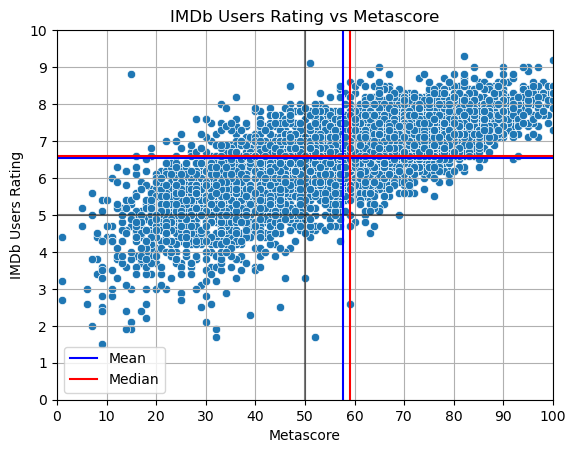

In [193]:
sns.scatterplot(x="metascore", y="imdb_rating", data=movies)
plt.title("IMDb Users Rating vs Metascore")
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 11, 1))
plt.xlim(0, 100)
plt.ylim(0, 10)
plt.xlabel("Metascore")
plt.ylabel("IMDb Users Rating")
plt.grid()

# plot center lines
plt.axhline(y=5, color='k', linestyle='-', alpha=0.5)
plt.axvline(x=50, color='k', linestyle='-', alpha=0.5)

# plot mean lines
plt.axhline(y=movies['imdb_rating'].mean(), color='b', linestyle='-')
plt.axvline(x=movies['metascore'].mean(), color='b', linestyle='-')

# plot median lines
plt.axhline(y=movies['imdb_rating'].median(), color='r', linestyle='-')
plt.axvline(x=movies['metascore'].median(), color='r', linestyle='-')

# legend the lines but not the scatter plots
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
plt.legend(handles=[blue_line, red_line])

plt.show()

From this plot we can see that:

- There appears to be a positive correlation between the IMDb user ratings and Metascore, suggesting that movies with higher critical acclaim (as indicated by Metascore) tend to also have higher user ratings on IMDb.

- The density of points (intersections of means/medians) tends to increase towards the top-right quadrant, indicating a concentration of movies that are both critically acclaimed and popular among users.

- There are few movies in the bottom-right quadrant, indicating that there are few movies that are critically acclaimed but not popular among users. And if so, they are very close to the center of the plot meaning that the difference between the IMDb user rating and Metascore is not very high.

- We can visually see that a lot of movies in the top-left quadrant moreover far from the center, meaning that there are a lot of movies that are popular among users but not critically acclaimed.

## Awards Analysis

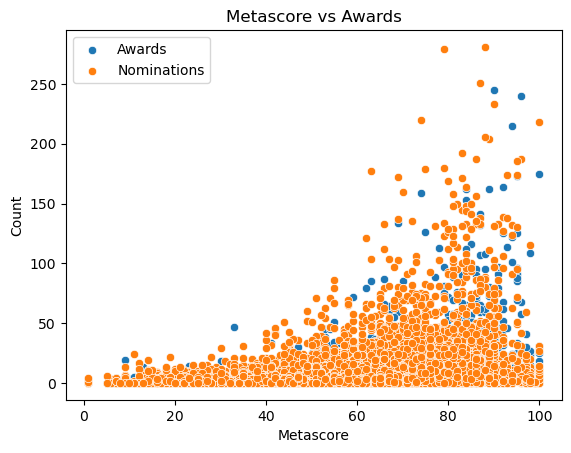

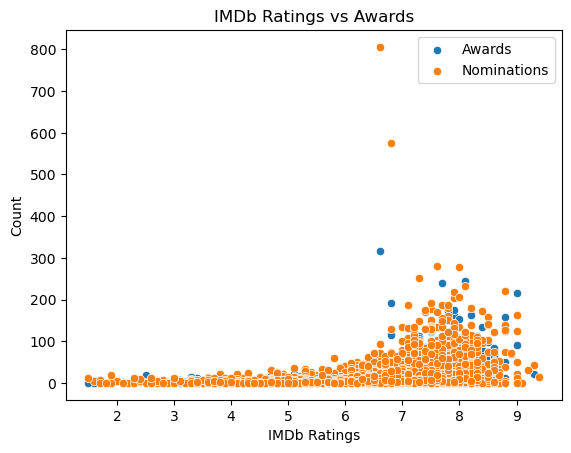

In [194]:
# Plot metascore vs nb awards
sns.scatterplot(x="metascore", y="count_award", data=movies)
sns.scatterplot(x="metascore", y="count_nomination", data=movies)
plt.title("Metascore vs Awards")
plt.ylabel("Count")
plt.xlabel("Metascore")
plt.legend(['Awards', 'Nominations'])
plt.show()

# Plot IMDb ratings vs nb awards
sns.scatterplot(x="imdb_rating", y="count_award", data=movies)
sns.scatterplot(x="imdb_rating", y="count_nomination", data=movies)
plt.title("IMDb Ratings vs Awards")
plt.ylabel("Count")
plt.xlabel("IMDb Ratings")
plt.legend(['Awards', 'Nominations'])
plt.show()



We can see that the number of awards is positively correlated with the metascore, but not much with the IMDb rating.

## Metacritics Analysis

In [195]:
# Load the data
metacritic_reviews = pd.read_csv('data/external/metacritic_reviews.csv')

In [201]:
metacritic_reviews.describe()

,metacritic_rating,metascore
count,159016.000000,157135.000000
mean,61.524186,58.773131
std,22.428662,17.666645
min,0.000000,1.000000
25%,50.000000,46.000000
50%,63.000000,60.000000
75%,75.000000,72.000000
max,100.000000,100.000000


In [215]:
display(metacritic_reviews['metacritic_id'].nunique())
display(movies['metacritic_id'].nunique())

8048

8528

Furthermore, we do observe that we have less movies having a metascore than movies having a review.

We do observe that even using a tailored scrapped dataset, some metascores are still missing. After research, we've found that a minimum of 4 reviews is required for a movie to have a metascore, hence the missing value. Furthermore, some movies are simply not rated on Metacritic. Those missing data will have to be handled with care.

### Metacritic ratings of publishers

In [216]:
top_publishers = metacritic_reviews \
    .groupby('publisher') \
    .agg({'metacritic_rating': ['count', 'mean', 'median']}) \
    .sort_values(by=[('metacritic_rating', 'count')], ascending=False) \
    .head(20) \
    .reset_index()

print('Top 20 most active publishers:')
top_publishers.sort_values(by=[('metacritic_rating', 'median')], ascending=False)

Top 20 most active publishers:


publisher metacritic_rating                  
                                             count       mean median
10               Chicago Tribune              4586  66.210423   75.0
6        San Francisco Chronicle              5098  62.305022   75.0
12             Chicago Sun-Times              4548  71.334433   75.0
19     Christian Science Monitor              3102  65.627982   75.0
3              Los Angeles Times              6040  62.759934   70.0
9           Entertainment Weekly              4782  65.611251   67.0
13                 The A.V. Club              4521  60.838752   67.0
8                  New York Post              4853  56.324542   63.0
15                  Boston Globe              4502  62.666593   63.0
16  The Globe and Mail (Toronto)              3665  59.557708   63.0
18                     USA Today              3214  62.920660   63.0
4              TV Guide Magazine              5363  60.305240   60.0
7                 Chicago Reader              4921  59.156269   60.0
1                        Variety              6905  61.559739   60.0
11           New York Daily News              4565  57.768894   60.0
2                Washington Post              6621  58.105120   60.0
17        The Hollywood Reporter              3649  61.836119   60.0
0             The New York Times              7483  59.997327   60.0
5                  Village Voice              5301  54.933032   50.0
14              Austin Chronicle              4513  54.862619   50.0

We can observe that some publishers tend to give higher ratings than others. The median for instance span from 50 to 75.

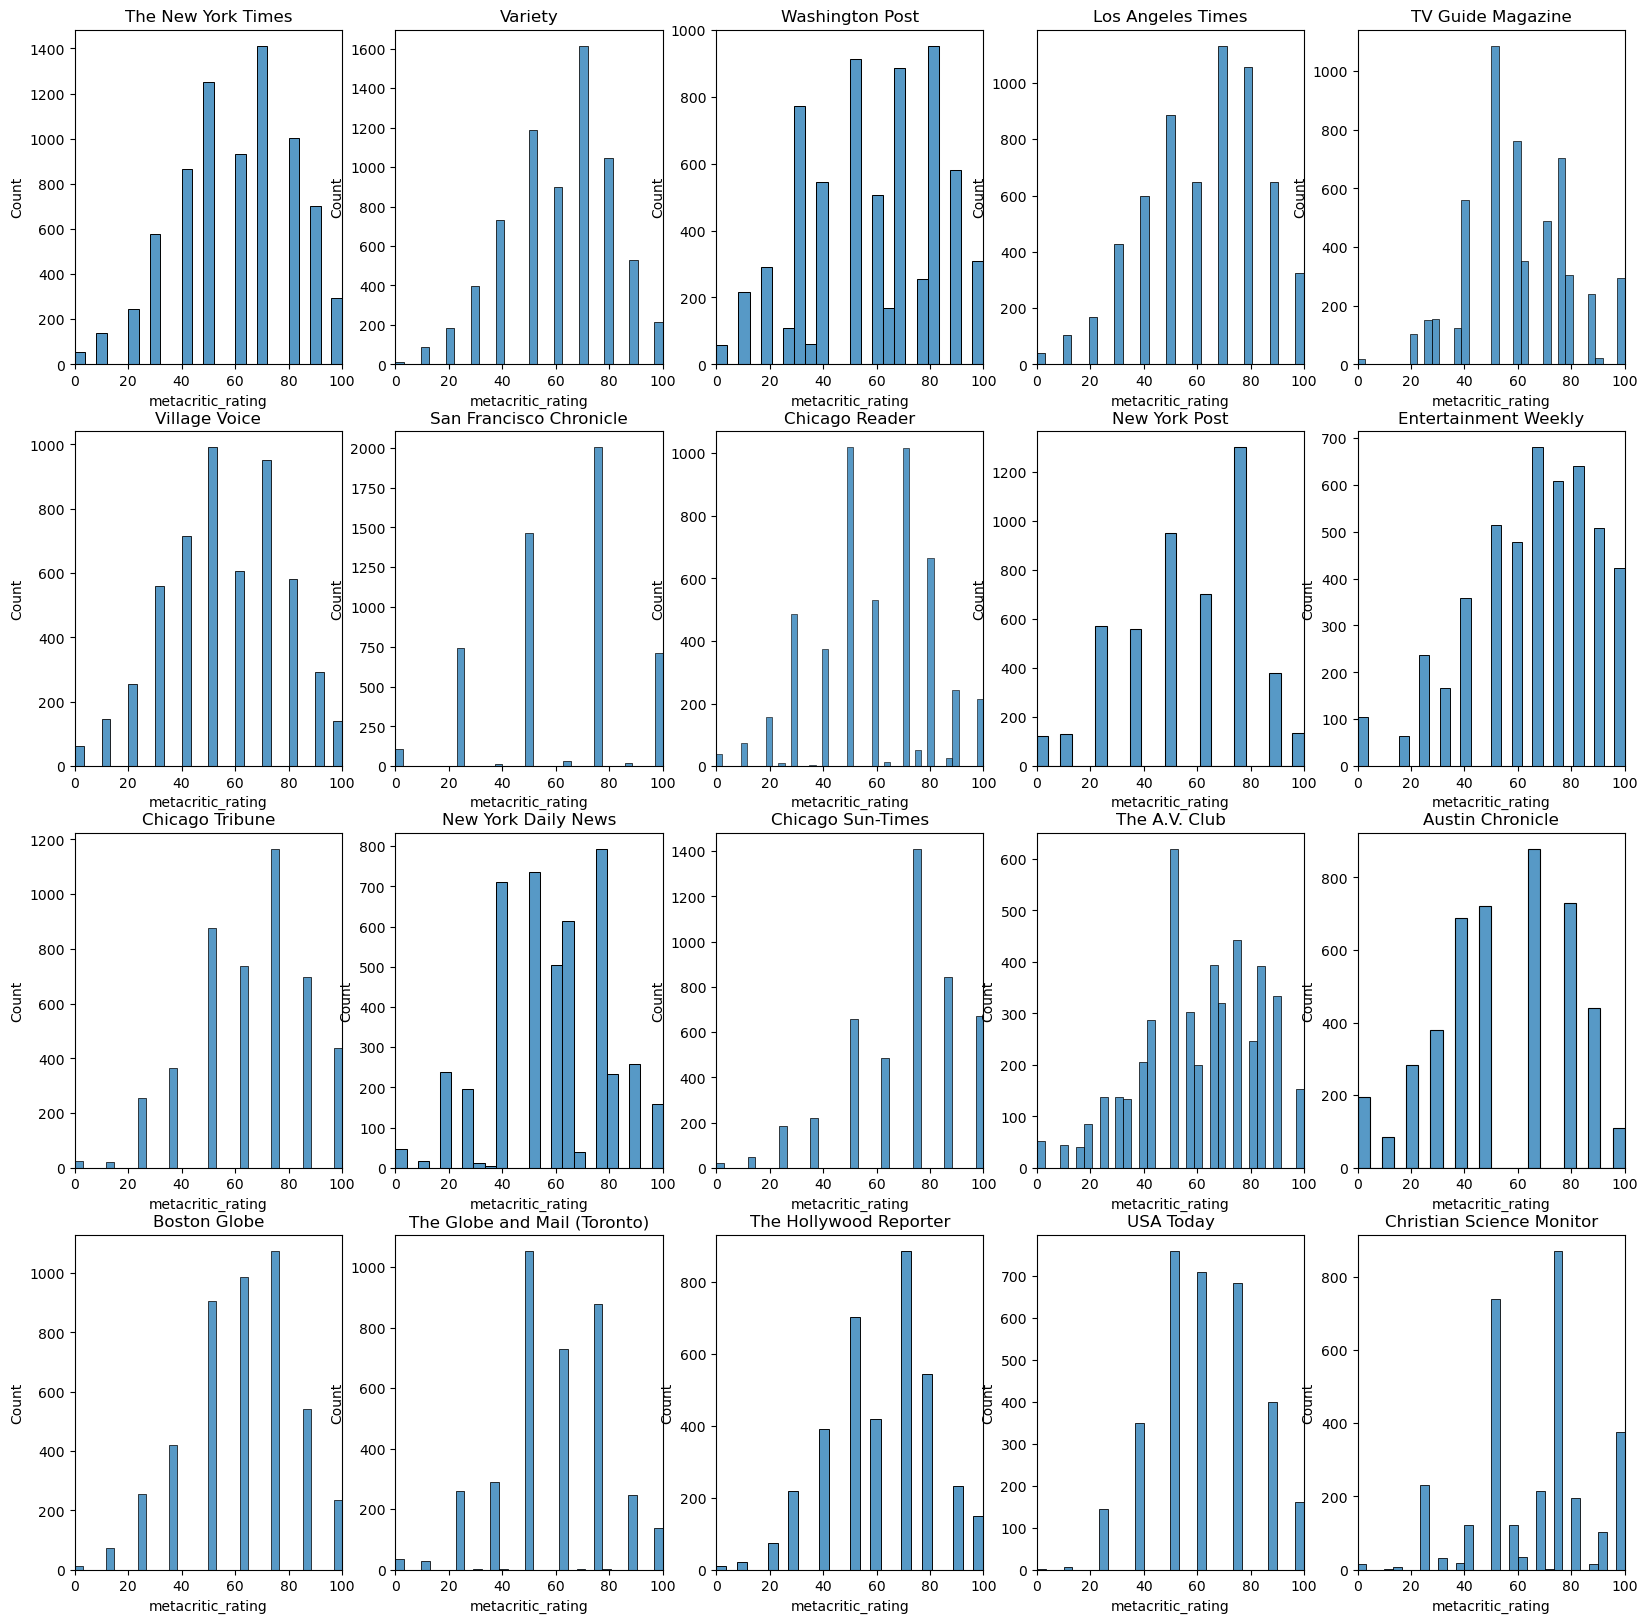

In [217]:
# Create one subplot for each publisher
top_publishers_names = top_publishers['publisher'].values

fig, axs = plt.subplots(len(top_publishers_names) // 5, 5, figsize=( 20, (len(top_publishers_names) // 5) * 5))

# plot the distribution of ratings for each publisher
for i, publisher in enumerate(top_publishers_names):
    ax = axs[i // 5][i % 5]
    ax.set_title(publisher)
    sns.histplot(metacritic_reviews.loc[metacritic_reviews['publisher'] == publisher]['metacritic_rating'], ax=ax)
    ax.set_xlim(0, 100)

plt.show()

### Metacritic ratings of genres

In [218]:
def extract_list(row, col_name):
    try:
        values_dict = ast.literal_eval(row[col_name])
        return list(values_dict.values())
    except:
        return []

# Merge movies and metacritic reviews
merged_metacritic_reviews = metacritic_reviews.merge(movies[['genres', 'metacritic_id']], on='metacritic_id', how='left')

# Apply the function to extract genres
merged_metacritic_reviews['extracted_genres'] = merged_metacritic_reviews.apply(lambda row: extract_list(row, 'genres'), axis=1)

# Explode the DataFrame to have a separate row for each genre
exploded_df = merged_metacritic_reviews.explode('extracted_genres').drop(columns=['genres'])

# Group by genre and calculate mean and count of ratings
grouped_df = exploded_df.groupby('extracted_genres').agg({'metacritic_rating': ['mean', 'count']})

# Sort by the count of ratings and take the top 10
print('Top 10 genres by mean metacritic_rating:')
print(grouped_df.sort_values(by=('metacritic_rating', 'mean'), ascending=False).head(10))

# Sort by the count of ratings and take the worse 10
print('\nWorse 10 genres by mean metacritic_rating:')
print(grouped_df.sort_values(by=('metacritic_rating', 'mean'), ascending=True).head(10))

Top 10 genres by mean metacritic_rating:
                     metacritic_rating      
                                  mean count
extracted_genres                            
British New Wave             92.000000    29
Ealing Comedies              90.000000     7
Propaganda film              89.766667    30
Foreign legion               88.800000    20
Cavalry Film                 86.916667    12
Pre-Code                     83.927536    69
World History                83.642857    42
Nuclear warfare              82.090909    11
Kitchen sink realism         82.000000     5
Epic Western                 81.827586    58

Worse 10 genres by mean metacritic_rating:
                      metacritic_rating      
                                   mean count
extracted_genres                             
Beach Film                    34.882353    34
Archaeology                   37.181818    33
Ninja movie                   40.000000    20
Softcore Porn                 41.266667    15
Gross-ou

### What's the most popular movies the New York Times critics didn't like ?

In [219]:
nyt_reviews = metacritic_reviews[metacritic_reviews['publisher'] == 'The New York Times'].drop(columns=['metascore'])

# Merge movies and NYT reviews
merged_nyt_reviews = nyt_reviews.merge(movies, on='metacritic_id', how='left')

In [220]:
# Find the most popular movies by imdb_rating and lowest metacritic_rating
print('Most popular movies by revenue and lowest metacritic_rating:')
merged_nyt_reviews.sort_values(by=['revenue', 'metacritic_rating'], ascending=[False, True]).head(10)

Most popular movies by revenue and lowest metacritic_rating:


,publisher,author,metacritic_rating,metacritic_id,wikipedia_id,freebase_id,name,revenue,runtime,languages,countries,genres,release_date_datetime,imdb_id,imdb_rating,imdb_votes,metascore,count_nomination,count_award
2212,The New York Times,Manohla Dargis,100.0,movie/avatar,4273140.0,/m/0bth54,Avatar,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2009-12-10,tt0499549,7.9,1364840.0,83.0,131.0,90.0
2062,The New York Times,NaN,100.0,movie/titanic,52371.0,/m/0dr_4,Titanic,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ...",1997-11-01,tt0120338,7.9,1252854.0,75.0,83.0,126.0
2628,The New York Times,A.O. Scott,40.0,movie/the-avengers-2012,22114132.0,/m/062zm5h,The Avengers,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ...",2012-04-11,tt0848228,8.0,1438871.0,69.0,80.0,38.0
2842,The New York Times,Manohla Dargis,90.0,movie/harry-potter-and-the-deathly-hallows-part-2,31941988.0,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,1.328111e+09,130.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/02n4kr"": ""Mystery""...",2011-07-07,tt1201607,8.1,923935.0,85.0,94.0,47.0
1708,The New York Times,A.O. Scott,60.0,movie/transformers-dark-of-the-moon,25001260.0,/m/0872p_c,Transformers: Dark of the Moon,1.123747e+09,157.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...",2011-06-23,tt1399103,6.2,426612.0,42.0,42.0,11.0
7419,The New York Times,A.O. Scott,100.0,movie/the-lord-of-the-rings-the-return-of-the-...,174251.0,/m/017jd9,The Lord of the Rings: The Return of the King,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj...",2003-12-17,tt0167260,9.0,1930163.0,94.0,124.0,215.0
5034,The New York Times,Manohla Dargis,80.0,movie/the-dark-knight-rises,29075630.0,/m/0bpm4yw,The Dark Knight Rises,1.078009e+09,165.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",2012-07-16,tt1345836,8.4,1786705.0,78.0,103.0,42.0
6377,The New York Times,A.O. Scott,100.0,movie/toy-story-3,1213838.0,/m/04hwbq,Toy Story 3,1.063172e+09,102.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/03k9fj"": ""Adventure"", ""/m/0hj3myq"": ""Chil...",2010-06-12,tt0435761,8.3,874757.0,92.0,96.0,62.0
1270,The New York Times,A.O. Scott,40.0,movie/pirates-of-the-caribbean-on-stranger-tides,24314116.0,/m/09v8clw,Pirates of the Caribbean: On Stranger Tides,1.043872e+09,136.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02qvnvs"": ""Swashbuckler films"", ""/m/03k9f...",2011-05-07,tt1298650,6.6,552626.0,45.0,31.0,3.0
4598,The New York Times,NaN,80.0,movie/star-wars-episode-i---the-phantom-menace,50793.0,/m/0ddt_,Star Wars Episode I: The Phantom Menace,1.027045e+09,136.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ...",1999-05-19,tt0120915,6.5,840111.0,51.0,71.0,28.0


We can see that the New York Times didn't like The Avengers with a rating of 40/100 but the movie is still very popular among users with a rating of 8.0/10 and a box office revenue of 1.5B$.

## Movies Analysis

In [221]:
print('Check for NaN values:')
print(movies.isna().sum())

Check for NaN values:
wikipedia_id                0
freebase_id                 0
name                        0
revenue                  3851
runtime                   412
languages                   0
countries                   0
genres                      0
release_date_datetime     144
imdb_id                     0
metacritic_id               0
imdb_rating                 1
imdb_votes                  1
metascore                 759
count_nomination            0
count_award                 0
dtype: int64


In [222]:
movies['release_date_datetime'] = pd.to_datetime(movies['release_date_datetime'], errors='coerce')

It's only a lot of missing value for revenue

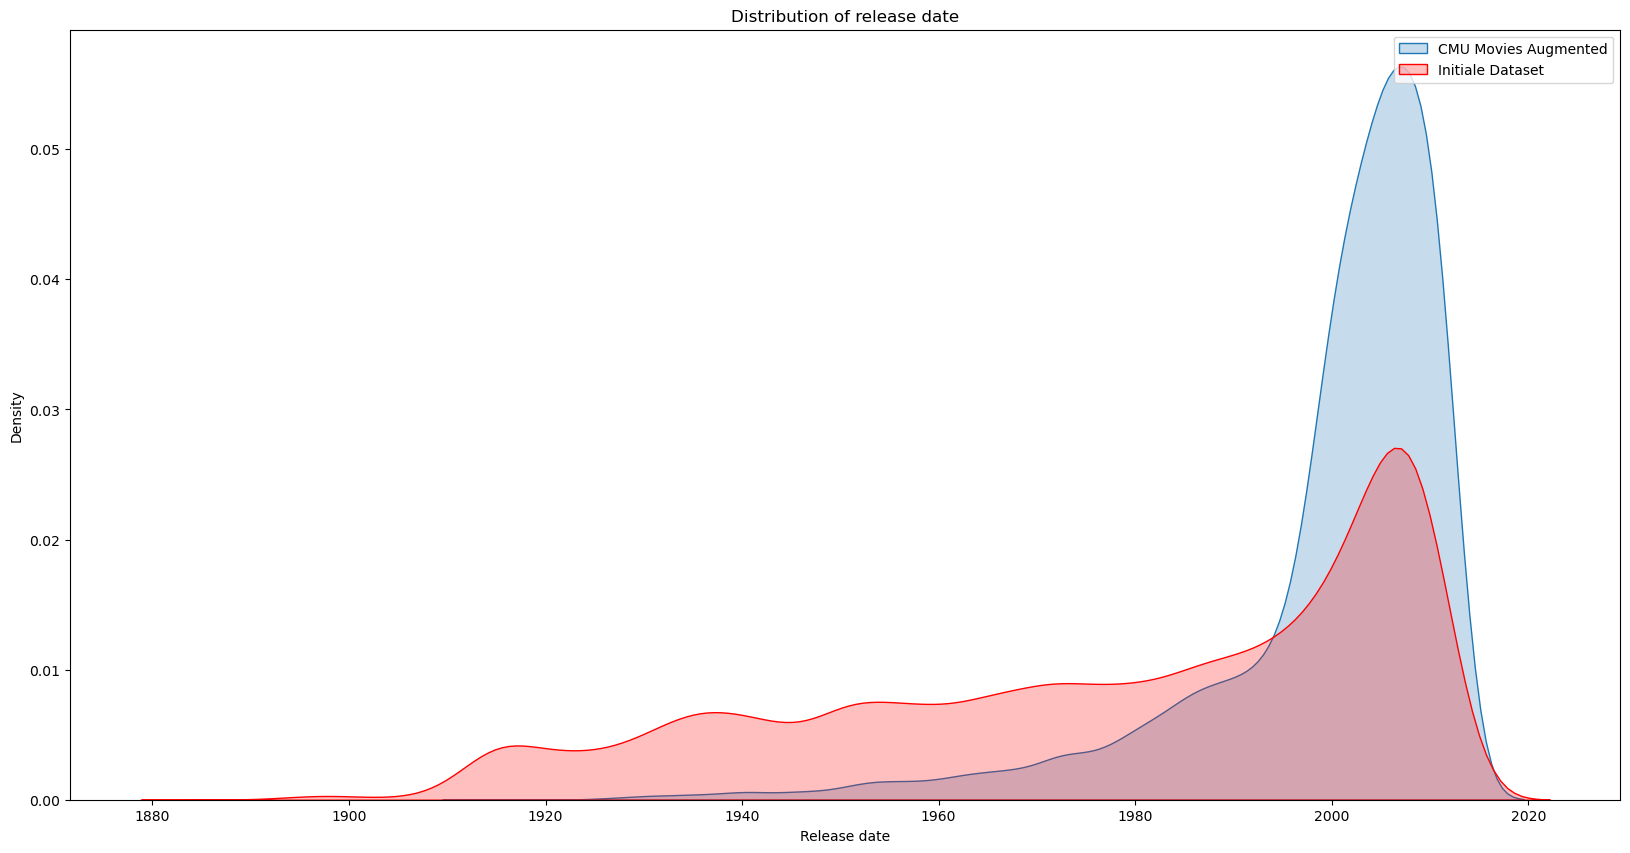

In [223]:
preprocessed_movies = pd.read_table('data/preprocessed/movie.metadata.preprocessed.tsv')
preprocessed_movies['release_date_datetime'] = pd.to_datetime(preprocessed_movies['release_date_datetime'], errors='coerce')

# Show the distribution of cmu_movie_augmented release date
plt.figure(figsize=(20,10))
plt.title('Distribution of release date')
plt.xlabel('Release date')
plt.ylabel('Density')

# Plot kdeplot of cmu_movies_augmented release date
sns.kdeplot(data=movies.dropna(subset=['release_date_datetime'])['release_date_datetime'].dt.year, fill=True)
sns.kdeplot(data=preprocessed_movies.dropna(subset=['release_date_datetime'])['release_date_datetime'].dt.year, fill=True, color='red')
plt.legend(['CMU Movies Augmented', 'Initiale Dataset'])
plt.show()



We lose some movies before 1980. Also a lot a movie between 1910 and 1960 are lost.

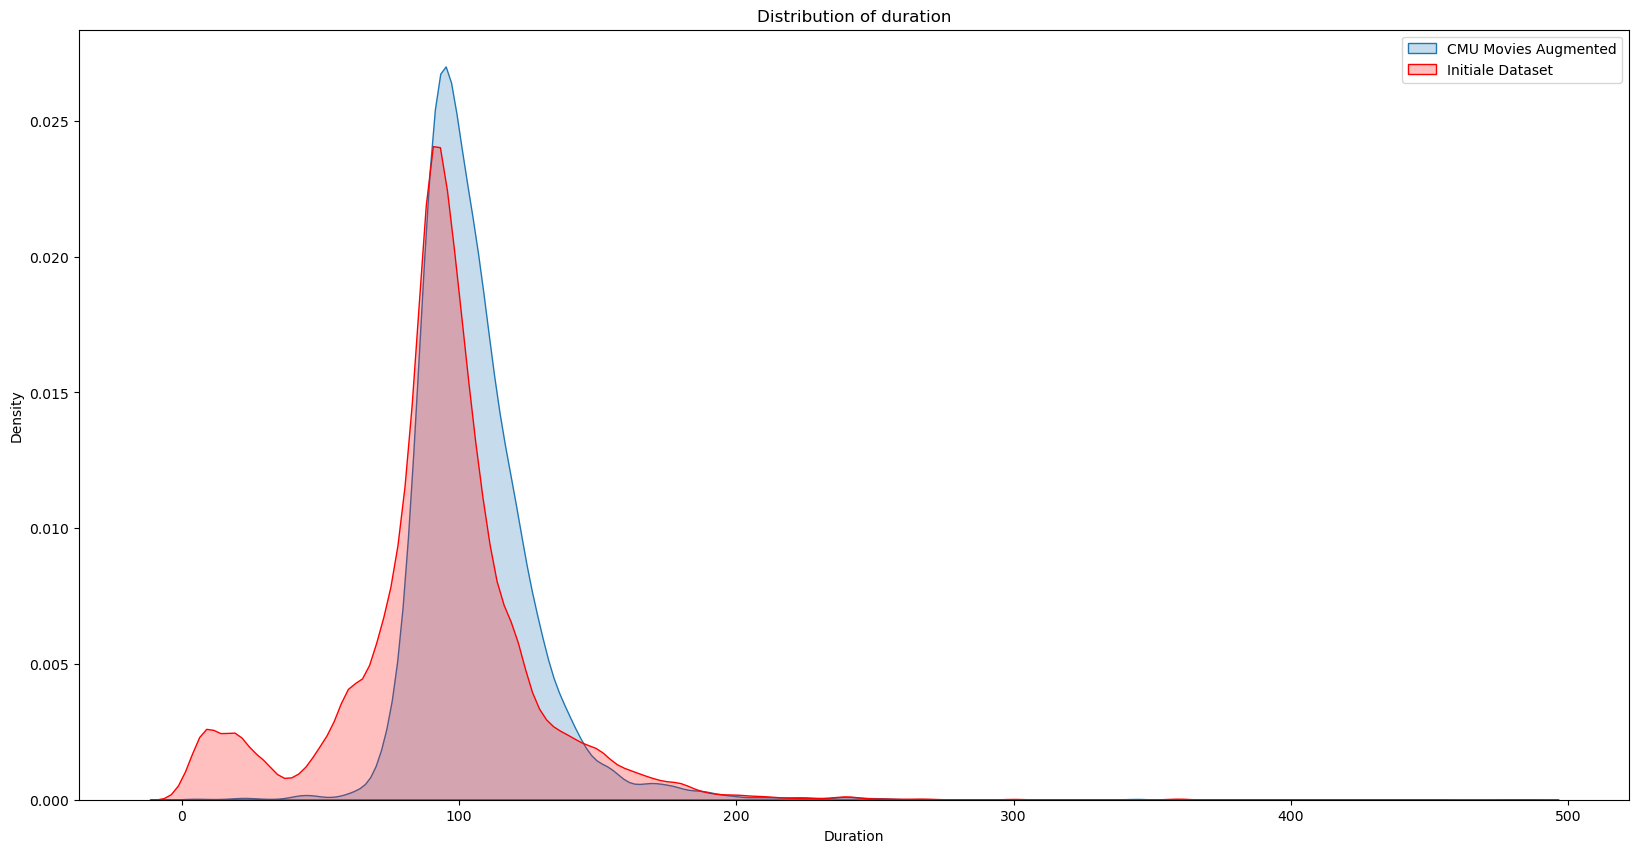

In [224]:
# Show the distribution of cmu_movie_augmented duration
plt.figure(figsize=(20,10))
plt.title('Distribution of duration')
plt.xlabel('Duration')
plt.ylabel('Density')

# Plot kdeplot of cmu_movies_augmented duration
sns.kdeplot(data=movies.dropna(subset=['runtime'])['runtime'], fill=True)
sns.kdeplot(data=preprocessed_movies.dropna(subset=['runtime'])['runtime'], fill=True, color='red')
plt.legend(['CMU Movies Augmented', 'Initiale Dataset'])
plt.show()

A lot of movies with duration smaller than 40min are deleted in the new dataset

In [225]:
#extract the list of genres of cmu_movies_augmented
movies_exploded = movies.copy()
movies_exploded['extracted_genres'] = movies_exploded.apply(lambda row: extract_list(row, 'genres'), axis=1)

#explode the genres
movies_exploded = movies_exploded.explode('extracted_genres')

In [226]:
# Extract the list of genres
preprocessed_movies_exploded = preprocessed_movies.copy()
preprocessed_movies_exploded['extracted_genres'] = preprocessed_movies_exploded.apply(lambda row: extract_list(row, 'genres'), axis=1)

# Explode the genres
preprocessed_movies_exploded = preprocessed_movies_exploded.explode('extracted_genres')

In [227]:
#create a new df with the count of each genre and merge with the initial df count of each genre
movies_count = movies_exploded['extracted_genres'].value_counts().reset_index()
movies_count.columns = ['extracted_genres', 'count_new']

preprocessed_movies_count = preprocessed_movies_exploded['extracted_genres'].value_counts().reset_index()
preprocessed_movies_count.columns = ['extracted_genres', 'count_old']

movies_count = movies_count.merge(preprocessed_movies_count, on='extracted_genres', how='left')
display(movies_count)

,extracted_genres,count_new,count_old
0,Drama,4700,33989
1,Comedy,2872,16347
2,Thriller,2054,8736
3,Romance Film,1850,10228
4,Indie,1503,6895
...,...,...,...
313,Cavalry Film,1,15
314,Psychological horror,1,5
315,Archaeology,1,10
316,Breakdance,1,1


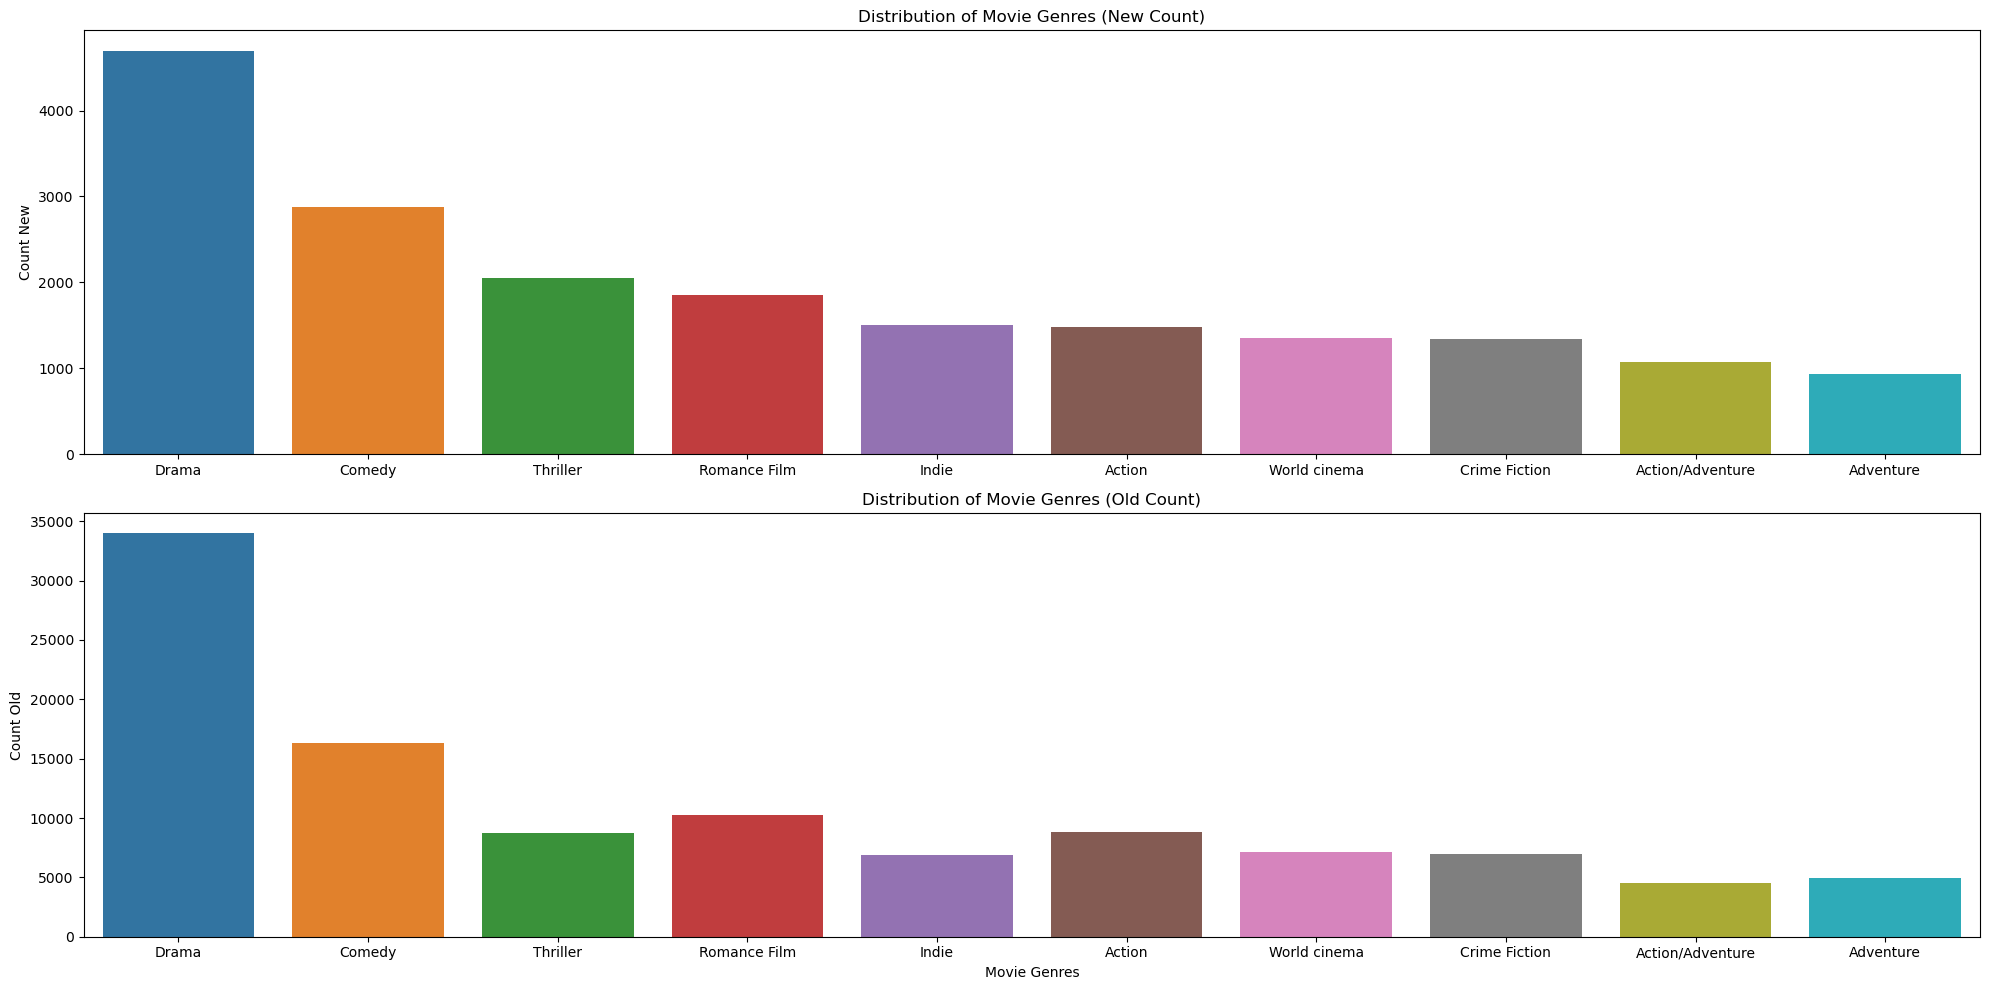

In [228]:
# Create figure and axes for subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# Seaborn barplot for new count
sns.barplot(x='extracted_genres', y='count_new', data=movies_count.head(10), ax=axs[0])
axs[0].set_title('Distribution of Movie Genres (New Count)')
axs[0].set_xlabel('')
axs[0].set_ylabel('Count New')

# Seaborn barplot for old count
sns.barplot(x='extracted_genres', y='count_old', data=movies_count.head(10), ax=axs[1])
axs[1].set_title('Distribution of Movie Genres (Old Count)')
axs[1].set_xlabel('Movie Genres')
axs[1].set_ylabel('Count Old')

# Adjust layout
plt.tight_layout()
plt.show()

The top 10 genres are the same as the top 10 genres in the original dataset.